# Differential Expression Analysis

In this exercise we will explore *RNA-seq data* from **lung biopsies** that have been sorted into **CD4+ T-cells**.  

Because alignment and read counting can take a long time, we will use **pre-calculated count tables** that summarize how many reads map to each gene.  

---

## What is DESeq2?

- RNA-seq produces **count data**: for each gene, how many reads were assigned.  
- DESeq2 uses a **statistical model (negative binomial distribution)** to detect which genes are expressed differently between two or more experimental conditions.  
- This approach is general and can also be applied to other count-based assays (e.g. ChIP-seq).  

---

## Why DESeq2?

- Widely used and well-validated.  
- Provides built-in methods for **normalization**, **dispersion estimation**, and **statistical testing**.  
- Integrated with the Bioconductor ecosystem in R.  

---

For this practical we will focus on interpreting the results rather than running the full alignment pipeline.


In [24]:
suppressPackageStartupMessages(library(DESeq2)) # load the DESeq2 package
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)
# Nicer default text size for ggplot objects (affects plotPCA etc.)
if (requireNamespace("ggplot2", quietly = TRUE)) {
  ggplot2::theme_set(ggplot2::theme_minimal(base_size = 14))
}

## Reading the input data

Now we will load the **input data** into our R session. The input consists of:

- A **count matrix**: genes × samples, with raw read counts.  
- **Sample metadata**: which sample belongs to which condition.  
- **Gene annotations**: such as gene name and biotype.  

These files are stored as **tab-delimited text files** (a common format for tables in bioinformatics).  


In [25]:
counts <- read.delim("data/counts.txt", sep="\t", check.names=FALSE, as.is=TRUE)
head(counts, n=5)

,6a,8a,B1,B13,B14,B17,B18,B2,B5,B6
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,10,0,3,2,16,10,0,9,14,2
ENSG00000000419,158,193,181,166,271,192,86,196,135,186
ENSG00000000457,276,280,219,259,424,366,326,445,195,286
ENSG00000000460,52,70,38,58,71,91,50,94,27,63
ENSG00000000938,104,38,575,487,83,346,64,139,694,201


## Understanding the count matrix

The **count matrix** looks like this:

- **Rows** = genes (identified by Ensembl IDs such as `ENSG0000012345`)  
- **Columns** = samples (one column per RNA-seq sample)  

Because Ensembl IDs are not always intuitive, we will also add extra information for each gene, such as:

- **Gene name** (e.g. `TP53`)  
- **Gene biotype** (e.g. protein-coding, lncRNA, pseudogene)  

---

> **Tip for exploration**:  
> Use `head(counts)` in R to look at the first few rows and get a sense of the data structure.  


In [26]:
head(counts, n=5)

,6a,8a,B1,B13,B14,B17,B18,B2,B5,B6
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,10,0,3,2,16,10,0,9,14,2
ENSG00000000419,158,193,181,166,271,192,86,196,135,186
ENSG00000000457,276,280,219,259,424,366,326,445,195,286
ENSG00000000460,52,70,38,58,71,91,50,94,27,63
ENSG00000000938,104,38,575,487,83,346,64,139,694,201


In [27]:
feature.info <- read.delim("data/feature_info.txt", sep="\t", row.names=1, check.names=FALSE) 
head(feature.info, n=5)

,gene_name,gene_biotype
,<chr>,<chr>
ENSG00000000003,TSPAN6,protein_coding
ENSG00000000419,DPM1,protein_coding
ENSG00000000457,SCYL3,protein_coding
ENSG00000000460,C1orf112,protein_coding
ENSG00000000938,FGR,protein_coding


## First quality check: highly abundant genes

Before running statistical tests, it is useful to check whether a few genes dominate the counts.  
If one or two genes have extremely high expression, they may **skew the normalization** and affect downstream results.  

We will therefore look at the genes with the **highest total counts** across all samples.  


In [28]:
gene.sum <- rowSums(counts)
top.abundant.genes <- rownames(counts)[order(-gene.sum)[1:10]]
abundance <- data.frame(feature.info[top.abundant.genes,], Total_Reads=gene.sum[top.abundant.genes], Fraction=100*(gene.sum/sum(gene.sum))[top.abundant.genes])

In [29]:
head(abundance, n=10)

,gene_name,gene_biotype,Total_Reads,Fraction
,<chr>,<chr>,<dbl>,<dbl>
ENSG00000210082,MT-RNR2,Mt_rRNA,3334794,2.6890050
ENSG00000156508,EEF1A1,protein_coding,2405694,1.9398269
ENSG00000198804,MT-CO1,protein_coding,1846076,1.4885800
ENSG00000211459,MT-RNR1,Mt_rRNA,1340327,1.0807702
ENSG00000150991,UBC,protein_coding,925433,0.7462212
ENSG00000075624,ACTB,protein_coding,907072,0.7314158
ENSG00000133112,TPT1,protein_coding,853724,0.6883988
ENSG00000166710,B2M,protein_coding,652559,0.5261897
ENSG00000167996,FTH1,protein_coding,583252,0.4703042


## Creating the sample information table

To run DESeq2 we need a **sample information table** (metadata).  
This table describes:

- Which samples belong to which condition (e.g. control vs treated).  
- Any additional grouping variables (e.g. batch, patient ID).  

We use the option `check.names=FALSE` in R so that the column names are not altered automatically.  
> **Question for you**: Which column names might be considered "invalid" by R without this option?


In [30]:
sample.info <- read.delim("data/sample_info.txt", sep="\t", check.names=FALSE)

In [31]:
sample.info$Sample_Group <- factor(sample.info$Sample_Group, levels=c("Control", "Cancer")) # make sure our condition is a factor with reference level first
head(sample.info, n=10)

,Sample_Biosource,Concentration,260_280,260_230,Sample_Group
,<chr>,<dbl>,<dbl>,<dbl>,<fct>
6a,CD4,3.20,1.80,0.30,Control
8a,CD4,6.20,1.89,0.10,Cancer
B1,CD4,35.30,2.29,1.41,Control
B13,CD4,6.60,2.16,0.07,Control
B14,CD4,7.10,1.42,0.14,Cancer
B17,CD4,11.80,2.17,0.66,Control
B18,CD4,8.10,1.51,0.28,Cancer
B2,CD4,12.30,1.98,1.09,Cancer
B5,CD4,5.91,1.87,0.31,Control


## Inspecting the sample information table

The **sample information table** contains one row per sample, and several columns with metadata.  
This metadata is essential because DESeq2 uses it to understand the experimental design.  

Common columns include:

- **Sample name**: must match the column names in the count matrix.  
- **Condition / Group**: the main variable we are testing (e.g. `control` vs `treated`).  
- **Replicate / Patient ID**: if samples are paired or grouped by biological source.  
- **Batch**: optional column for technical variation (e.g. sequencing run).  

In our dataset, there are also additional columns from **Nanodrop or quality-control measurements**, such as:

- **Concentration**: RNA concentration (ng/µL) 260 nm.  
- **260/280 ratio**: purity indicator (protein contamination).  
- **260/230 ratio**: indicator of salt or reagent contamination.  

---

Why is this useful?  

- DESeq2 will *not* use these QC columns in the analysis directly, but they help us **document sample quality**.  
- If we see unexpected clustering or outliers later (e.g. in PCA), we can check whether they correlate with poor RNA quality.  
- Good practice: always keep QC metadata attached to your dataset for reference.  

---

> **Check carefully**:  
> - Do all samples in this table match the count matrix?  
> - Are the condition labels correctly entered?  
> - Do the QC values look reasonable ?


## Setting up the DESeq2 dataset

Now we combine the three inputs:

1. **Count matrix** (genes × samples).  
2. **Sample information table** (metadata).  
3. **Gene annotations**.  

Together these form a `DESeqDataSet` object in R, which is the standard input for all downstream steps in DESeq2.  

> Think of this object as the "analysis-ready" version of our data, combining both numbers and metadata in one structure.


In [32]:
de <- DESeqDataSetFromMatrix(as.matrix(round(counts)), colData = sample.info, rowData=feature.info, design=~Sample_Group)

converting counts to integer mode



In [33]:
de <- DESeq(de)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Normalization of counts

Raw counts are **not directly comparable** between samples, because:

- Different samples can have **different sequencing depths** (total number of reads).  
- Some samples may have a higher proportion of highly expressed genes, which skews the distribution.  

DESeq2 solves this by calculating **size factors** for each sample.  
These size factors act like scaling constants, bringing all samples to a comparable level.  

> **Key idea**: After normalization, differences in counts should mainly reflect *biological variation*, not sequencing depth.


## Filtering lowly expressed genes (teaching note)

In many RNA-seq pipelines, genes with very low counts are filtered out **before** testing.  
This helps reduce noise and avoid wasting statistical power on genes that are never expressed.  

However, **DESeq2 already performs independent filtering automatically** when you call the `results()` function.  
This means that low-count genes are excluded from the final significance testing step, without extra manual work.  

---

> **Simplified message**:  
> - You do not need to manually filter genes in DESeq2.  
> - It is good to know that filtering exists, because you may see slightly fewer genes tested than in the raw matrix.  


## Exploratory data analysis: PCA

Before testing for differential expression, it is crucial to check whether the data behaves as expected.  

A **Principal Component Analysis (PCA)** plot shows:

- Each point = one sample.  
- Samples are grouped based on overall expression patterns.  
- Axes (PC1, PC2) represent the main sources of variation.  

**How to interpret:**
- Samples from the same condition (here: `Sample_Group`) should cluster together.  
- Outliers may indicate poor quality, contamination, or mislabeled samples.  

PCA is one of the most important quality-control steps in RNA-seq analysis.


using ntop=500 top features by variance



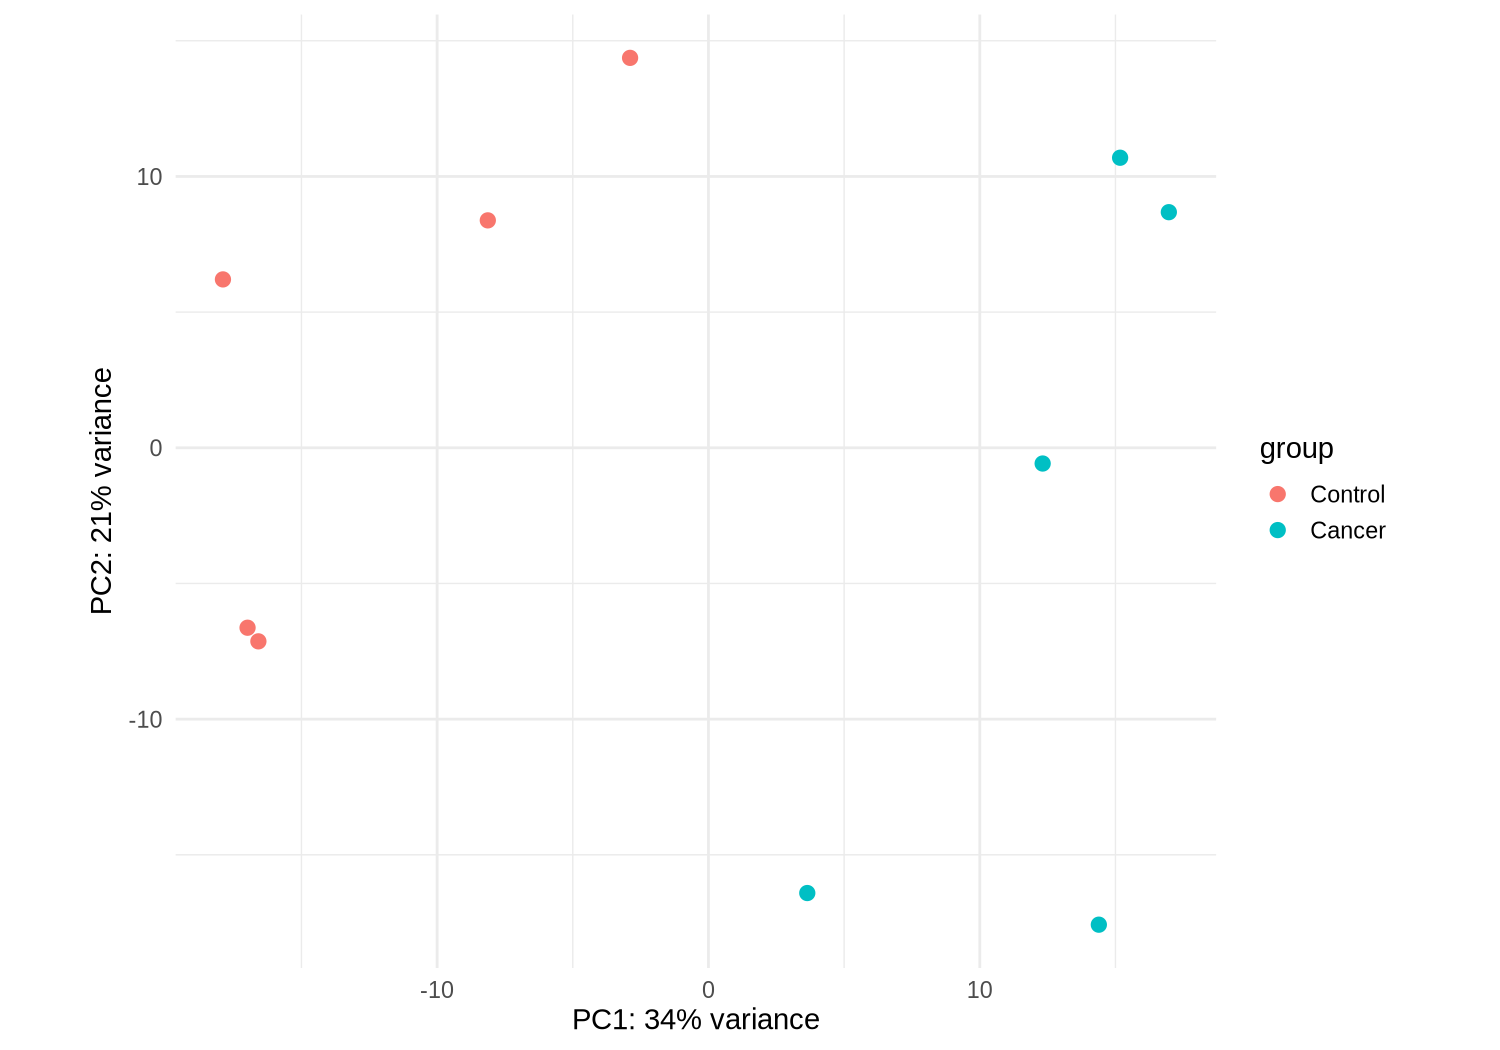

In [34]:
# Variance stabilizing transformation (better for PCA)
vsd <- vst(de, blind = FALSE)

# PCA plot, grouping by Sample_Group
plotPCA(vsd, intgroup = "Sample_Group")


-------------------

## Running the DESeq2 model and setting the comparison

We fit the DESeq2 model using our design `~ Sample_Group`.  
The **reference level** is explicitly set to `Control`, and the **contrast** compares `Cancer` **vs** `Control`.

**Interpretation of signs:**
- A **positive** log2 fold change (LFC) means **higher** expression in `Cancer` relative to `Control`.
- A **negative** LFC means **lower** expression in `Cancer` relative to `Control`.

We will first compute results with the **raw (MLE) LFCs**, then apply **LFC shrinkage** for more stable effect sizes — especially useful for low-count genes.


In [35]:
res.cd4 <- results(de)
summary(res.cd4)


out of 23656 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1130, 4.8%
LFC < 0 (down)     : 1115, 4.7%
outliers [1]       : 179, 0.76%
low counts [2]     : 5496, 23%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Understanding the results table

The `results()` table includes these key columns:

- **baseMean**: average normalized count across all samples.
- **log2FoldChange**: effect size (Cancer vs Control); positive = higher in Cancer.
- **lfcSE**: standard error of the LFC.
- **stat**: Wald test statistic.
- **pvalue**: unadjusted p-value.
- **padj**: FDR-adjusted p-value (Benjamini–Hochberg).

By default, DESeq2 applies **independent filtering** inside `results()`, which removes very low-information genes to improve detection power. This is automatic; you do **not** need to manually filter.


## MA plot (raw MLE fold changes)

The **MA plot** shows:
- **x-axis (A)**: mean expression (`baseMean`)
- **y-axis (M)**: log2 fold change (Cancer vs Control)

Points far from 0 on the y-axis indicate stronger differential expression.
Large scatter at low counts is expected due to higher uncertainty.

We will first look at the **raw (unshrunken) LFCs**, then compare to the **shrunken** LFCs in the next cell.


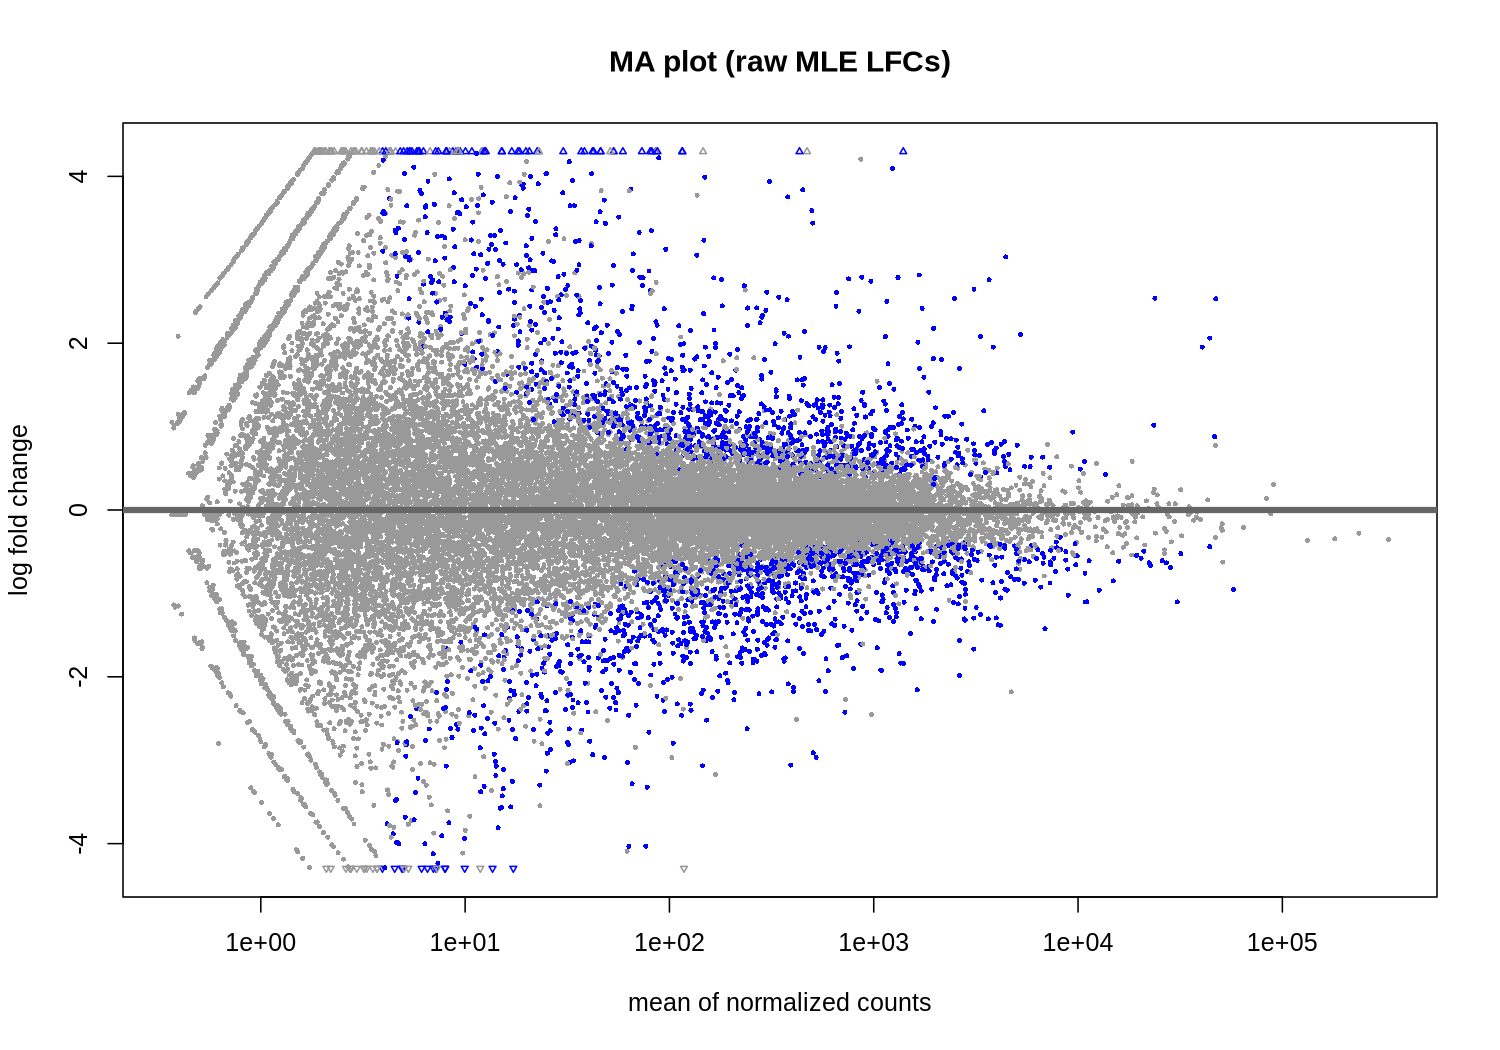

In [36]:
plotMA(res.cd4, main = "MA plot (raw MLE LFCs)")


## Shrinking log2 fold changes (more stable effect sizes)

**Why shrink LFCs?**
- Low-count genes can have exaggerated LFC estimates.
- LFC shrinkage pulls extreme values toward 0 when evidence is weak, improving **ranking**, **plots**, and **interpretability**.

We use `lfcShrink()` with the contrast `c("Sample_Group","Cancer","Control")`.  
For teaching clarity, we’ll show the MA plot again using the **shrunken** LFCs.

> **Note:** In newer workflows, `type="apeglm"` is often recommended for shrinkage. This notebook uses `type="normal"` for simplicity.


using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



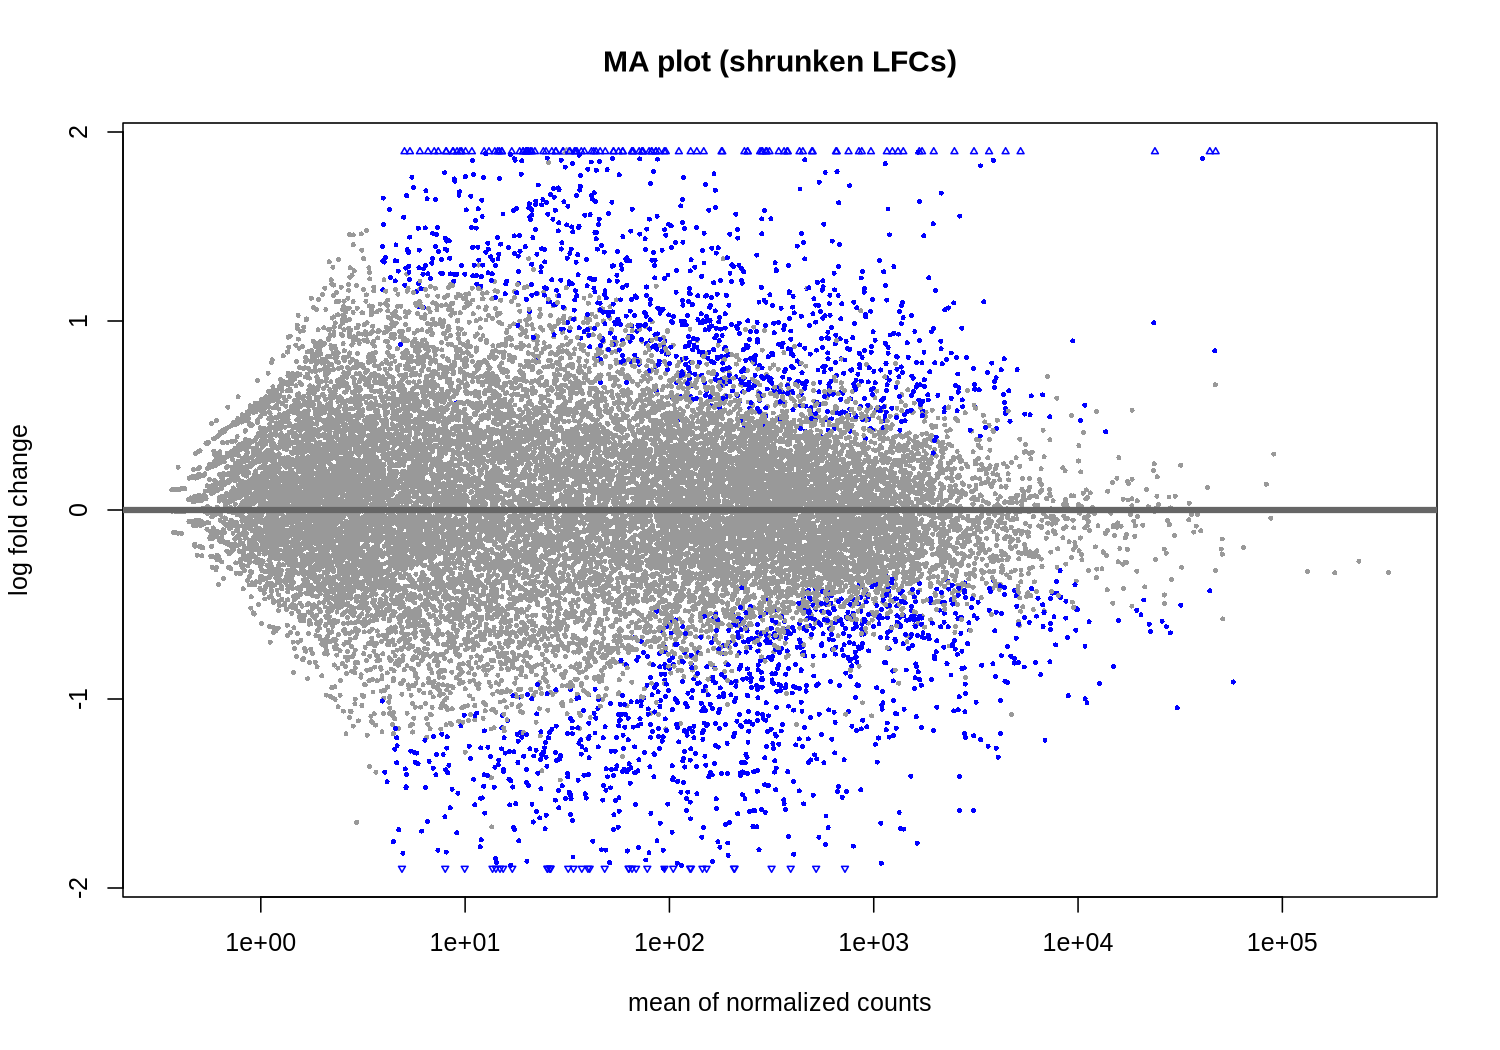

In [37]:
lfc.cd4 <- lfcShrink(de, contrast=c("Sample_Group","Cancer","Control"), res=res.cd4, type="normal" )
plotMA(lfc.cd4, main = "MA plot (shrunken LFCs)")

### Interpreting the MA plot with shrunken LFCs

This MA plot looks similar to the earlier one, but with an important difference:  
the **log2 fold changes (y-axis)** have been **shrunk** toward 0 for genes with weak evidence.  

---

**What you should notice:**

- The **cloud of points at low counts** is now tighter around 0.  
  - Low-count genes have higher uncertainty, so their fold changes are pulled closer to zero.  
- For **highly expressed genes**, shrinkage has little effect.  
  - Strong signals remain visible and stand out as blue points.  

---

**Why is this useful?**

- It makes the **ranking of genes** by effect size more reliable.  
- It avoids inflated fold changes for weakly supported genes.  
- This is especially important when using **LFC cutoffs** (e.g. only reporting genes with |log2FC| > 1).  

---

> **Take-home message:**  
> Shrinkage stabilizes fold change estimates, making them more useful for **ranking genes** and applying **LFC thresholds** in downstream interpretation.


In [38]:
summary(lfc.cd4)


out of 23656 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1130, 4.8%
LFC < 0 (down)     : 1115, 4.7%
outliers [1]       : 179, 0.76%
low counts [2]     : 5496, 23%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [39]:
head(lfc.cd4, n=5)

log2 fold change (MAP): Sample_Group Cancer vs Control 
Wald test p-value: Sample Group Cancer vs Control 
DataFrame with 5 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003   6.20613     -0.3312735  0.496662 -0.665873 5.05492e-01
ENSG00000000419 172.64093      0.0861939  0.251740  0.342395 7.32054e-01
ENSG00000000457 298.43293      0.3525134  0.180344  1.954591 5.06314e-02
ENSG00000000460  59.51122      0.3267192  0.293595  1.112592 2.65884e-01
ENSG00000000938 274.47564     -1.7965499  0.385602 -4.660904 3.14823e-06
                       padj
                  <numeric>
ENSG00000000003 0.790930129
ENSG00000000419 0.904757975
ENSG00000000457 0.241806766
ENSG00000000460 0.596582010
ENSG00000000938 0.000179709

In [40]:
lfc.cd4 <- lfc.cd4[order(lfc.cd4$pvalue),]
head(lfc.cd4, n=5)

log2 fold change (MAP): Sample_Group Cancer vs Control 
Wald test p-value: Sample Group Cancer vs Control 
DataFrame with 5 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000091972  308.8808        3.65555  0.254930   14.2483 4.59436e-46
ENSG00000187601  502.7077        3.16111  0.271322   11.6272 2.99827e-31
ENSG00000235304   82.0432        4.88556  0.372592   11.4038 4.00057e-30
ENSG00000125538 1089.9027       -1.86868  0.171313  -10.9058 1.08182e-27
ENSG00000003147  449.9385        3.38241  0.321146   10.5065 8.06629e-26
                       padj
                  <numeric>
ENSG00000091972 8.26112e-42
ENSG00000187601 2.69559e-27
ENSG00000235304 2.39781e-26
ENSG00000125538 4.86306e-24
ENSG00000003147 2.90080e-22

## Volcano plot

A **volcano plot** combines both statistical significance and effect size in one figure:

- **x-axis**: log2 fold change (Cancer vs Control)  
- **y-axis**: –log10(adjusted p-value)  

This makes it easy to identify genes that are:  
- **Far left or right**: large fold changes.  
- **High on the plot**: statistically significant.  
- **Top corners**: strong candidates for biologically meaningful DE genes.  

Dashed lines are often added to show cutoffs, for example:  
- |log2FC| > 1 (fold change cutoff)  
- FDR < 0.05 (significance cutoff)  

Genes that fall beyond both thresholds are the most interesting for downstream interpretation.


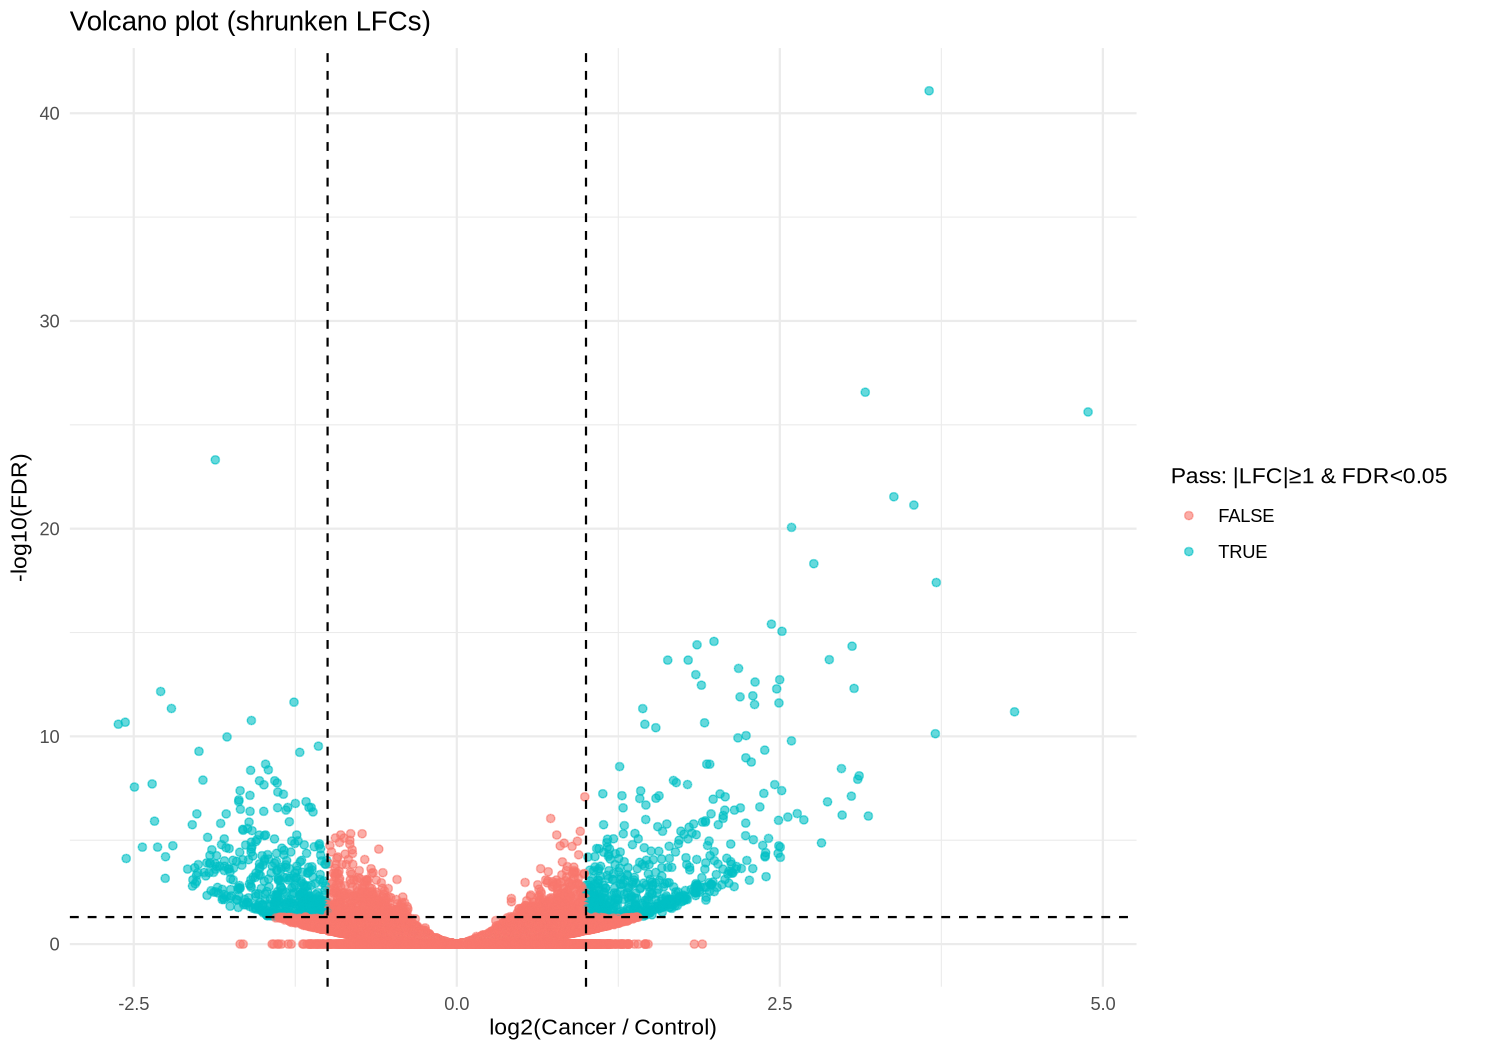

In [41]:
# Volcano plot from shrunken LFCs (lfc.cd4)
# Assumes you've already run: lfc.cd4 <- lfcShrink(...)

library(ggplot2)

# Prepare data frame
vol <- as.data.frame(lfc.cd4)
vol$gene <- rownames(vol)

# Handle missing/zero padj for plotting
vol$padj[is.na(vol$padj)] <- 1
vol$neglog10padj <- -log10(vol$padj)
# Clamp Inf values (can occur if padj == 0)
if (any(!is.finite(vol$neglog10padj))) {
  finite_max <- max(vol$neglog10padj[is.finite(vol$neglog10padj)], na.rm = TRUE)
  vol$neglog10padj[!is.finite(vol$neglog10padj)] <- finite_max + 1
}

# Thresholds (adjust if you want)
lfc_cutoff <- 1
fdr_cutoff <- 0.05

# Flag genes that pass BOTH thresholds
vol$pass <- with(vol, abs(log2FoldChange) >= lfc_cutoff & padj < fdr_cutoff)

# Plot
ggplot(vol, aes(x = log2FoldChange, y = neglog10padj)) +
  geom_point(aes(color = pass), alpha = 0.6) +
  geom_vline(xintercept = c(-lfc_cutoff, lfc_cutoff), linetype = "dashed") +
  geom_hline(yintercept = -log10(fdr_cutoff), linetype = "dashed") +
  labs(
    title = "Volcano plot (shrunken LFCs)",
    x = "log2(Cancer / Control)",
    y = "-log10(FDR)"
  ) +
  theme_minimal() +
  guides(color = guide_legend(title = paste0("Pass: |LFC|≥", lfc_cutoff, " & FDR<", fdr_cutoff)))


### Interpreting the volcano plot

This plot combines **effect size** and **statistical significance**:

- **x-axis:** log2 fold change (Cancer vs Control).  
  - **> 0** → higher in **Cancer**  
  - **< 0** → higher in **Control**
- **y-axis:** –log10(FDR).  
  - Higher values = **more significant**

The dashed lines mark our thresholds:
- **Vertical:** `|log2FC| ≥ 1` (biological effect size)
- **Horizontal:** `FDR < 0.05` (statistical significance)

**How to read it**
- Points in the **top-right**: significantly **upregulated** in Cancer.  
- Points in the **top-left**: significantly **downregulated** in Cancer.  
- Points near the center or below the horizontal line: weak or non-significant changes.

**Why we used shrunken LFCs**
- Shrinkage reduces exaggerated fold changes for low-count genes.
- This makes **ranking by effect size** and applying **LFC cutoffs** more reliable.

**Next steps**
- Focus on genes that pass **both** thresholds (highlighted in the legend).  
- Optionally label the top hits and inspect them with `plotCounts()` to confirm clear group differences.


In [42]:
sig.cd4 <- subset(lfc.cd4, padj < 0.01 & abs(log2FoldChange) > 1)
summary(sig.cd4) 


out of 668 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 365, 55%
LFC < 0 (down)     : 303, 45%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



How many significantly differentially expressed genes do you get? 


The gene identifiers we work with above are Ensembl gene IDs. These are useful as unique identifiers, but does not tell us anything about what the genes do so lets add the feature info. We also convert the table to a data frame, so that we can manipulate and view it more easily:

In [43]:
r.cd4 <- cbind(rowData(de[rownames(sig.cd4),])[,c("gene_name", "gene_biotype")], sig.cd4)
r.cd4 <- as.data.frame(r.cd4)
rownames(r.cd4) <- rownames(sig.cd4)
head(r.cd4, n=15)

,gene_name,gene_biotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000091972,CD200,protein_coding,308.88085,3.655553,0.2549300,14.248283,4.594363e-46,8.261124e-42
ENSG00000187601,MAGEH1,protein_coding,502.70770,3.161109,0.2713223,11.627184,2.998268e-31,2.695593e-27
ENSG00000235304,LINC01281,lincRNA,82.04318,4.885560,0.3725924,11.403844,4.000574e-30,2.397811e-26
ENSG00000125538,IL1B,protein_coding,1089.90272,-1.868678,0.1713133,-10.905763,1.081822e-27,4.863061e-24
ENSG00000003147,ICA1,protein_coding,449.93853,3.382408,0.3211463,10.506462,8.066292e-26,2.900800e-22
ENSG00000149257,SERPINH1,protein_coding,1233.86635,3.537199,0.3401289,10.401585,2.438441e-25,7.307600e-22
ENSG00000030419,IKZF2,protein_coding,1314.71701,2.590573,0.2551931,10.147948,3.384043e-24,8.692639e-21
ENSG00000173110,HSPA6,protein_coding,4420.55166,2.762929,0.2838622,9.734262,2.153759e-22,4.840843e-19
ENSG00000172817,CYP7B1,protein_coding,53.30352,3.711070,0.3696401,9.507290,1.956941e-21,3.909750e-18


## Inspecting specific genes of interest

After looking at the global results, it is useful to drill down to **individual genes**.  
This helps connect the statistical output to something more intuitive: the actual counts per sample.  

---

**How to use this step:**

1. Pick a gene that passes both cutoffs:  
   - **padj < 0.05** (statistically significant)  
   - **|log2FoldChange| > 1** (biologically meaningful effect size)  

2. Plot its counts across the groups (here: `Sample_Group`).  
   - The plot shows normalized counts, so differences are directly comparable.  
   - You should see a clear separation between groups for strong DE genes.  

---

> **Teaching point:**  
> Inspecting a few top genes visually helps confirm that the statistical results reflect clear biological differences, not just noise.  


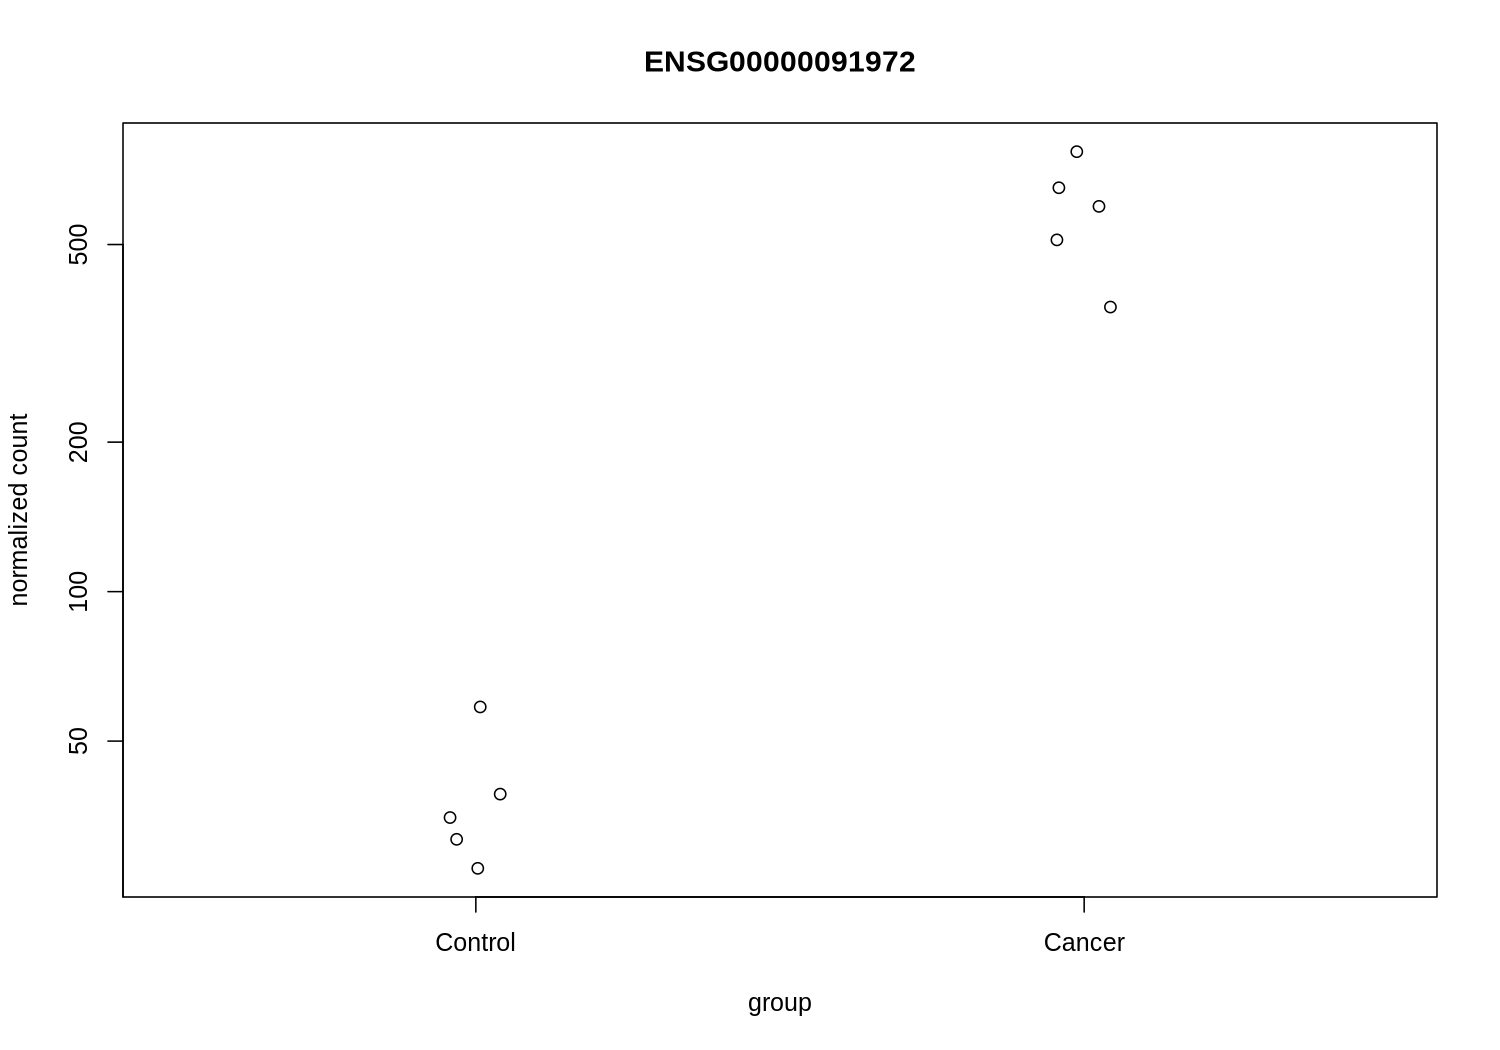

In [44]:
plotCounts(de, "ENSG00000091972", intgroup="Sample_Group")

## Histogram of p-values

A histogram of p-values is a simple but powerful diagnostic tool.

- **Null expectation:**  
  If no genes are truly differentially expressed, p-values should be **uniformly distributed** between 0 and 1.

- **Real biology present:**  
  If many genes are truly differentially expressed, the histogram will show an **excess of very small p-values** near 0.

- **Problems to watch for:**  
  - A spike at 1 may suggest issues with model fit or filtering.  
  - A flat histogram with no enrichment near 0 suggests no real signal in the data.  

> **Take-home message:**  
> A healthy dataset often shows a flat background with a clear enrichment of small p-values near zero.


Details at http://varianceexplained.org/statistics/interpreting-pvalue-histogram/ . 

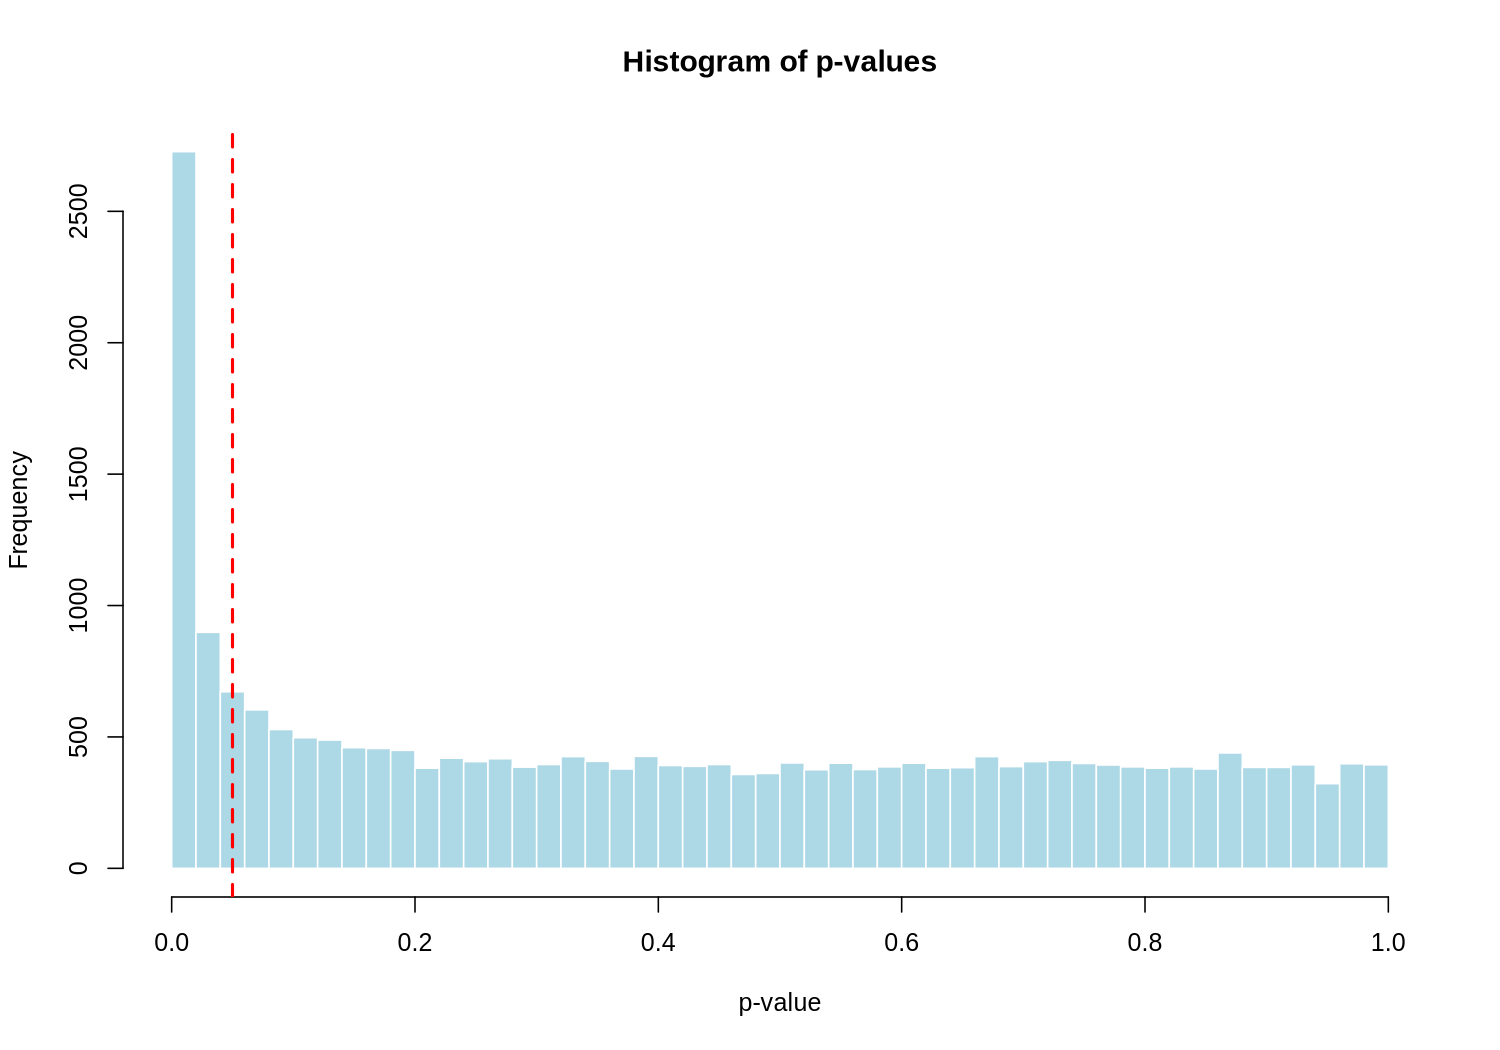

In [45]:
# Histogram of raw p-values
hist(res.cd4$pvalue,
     breaks = 50,
     col = "lightblue",
     border = "white",
     main = "Histogram of p-values",
     xlab = "p-value")

# Optional: add a vertical line at 0.05
abline(v = 0.05, col = "red", lwd = 2, lty = 2)


## Summary & checklist: from counts to biological insight

We have walked through a complete RNA-seq differential expression workflow using DESeq2:

1. **Data inputs**
   - **Count matrix** (genes × samples)
   - **Sample metadata** (e.g. `Sample_Group`)
   - **Gene annotations** (names/biotypes)

2. **Normalization**
   - DESeq2 estimates **size factors** so samples with different sequencing depth become comparable.

3. **Quality control (QC)**
   - **PCA** on variance-stabilized counts checks whether samples group by `Sample_Group` and reveals outliers or batch effects.

4. **Model fitting**
   - Negative binomial GLM with design `~ Sample_Group`.
   - **Results table** gives `log2FoldChange`, `pvalue`, `padj` (FDR).
   - **Independent filtering** is applied automatically in `results()`.

5. **Effect sizes & shrinkage**
   - **LFC shrinkage** stabilizes fold changes for low-count genes.
   - Important for **ranking genes** and applying **|log2FC| cutoffs**.

6. **Visual summaries**
   - **MA plot**: mean expression vs (shrunken) LFC; highlights magnitude and direction of change.
   - **Volcano plot**: (shrunken) LFC vs –log10(FDR); top-left/top-right corners show the strongest DE genes.
   - **p-value histogram**: uniform background with enrichment near 0 indicates real biological signal.
   - **Heatmap (top DE genes)**: samples should separate by group; shows co-expression patterns.
   - **plotCounts()** for single genes: sanity-check that group differences are visible in normalized counts.

---

### How to report results (practical checklist)

- Choose **cutoffs** that reflect your biological question:
  - **Significance**: e.g. `padj < 0.05`
  - **Effect size**: e.g. `|log2FC| ≥ 1`
- Export a results table including: gene ID, gene name, baseMean, shrunken log2FC, padj.
- Highlight **top genes** (rank by padj or by |shrunken log2FC| within padj < 0.05).
- Include **figures**: PCA, MA (shrunken), volcano with cutoffs, and a heatmap of top DE genes.
- Inspect a few representative genes with `plotCounts()`.

---

### Common pitfalls & reminders

- **Replicates matter**: too few replicates reduce power and make dispersion estimation less reliable.
- **Batch effects**: if present, include batch in the design (e.g. `~ Batch + Sample_Group`) and re-run PCA/DE.
- **Interpret signs** carefully: here, positive LFC means **higher in Cancer vs Control**; negative means **higher in Control**.
- **Gene IDs vs names**: report both; IDs are stable, names are readable.
- **Multiple testing**: focus on **FDR (padj)**, not raw p-values.

---

### Suggested next steps

- Perform **functional enrichment** (GO/KEGG) on significant genes.
- Cross-check top genes with **literature** or **external datasets**.
- Validate a few candidates by **qPCR** or **orthogonal assays** when possible.

> **Take-home message:** Combine **FDR** (statistical evidence) with **|log2FC|** (biological effect size), confirm patterns with visualizations, and always interpret results in the context of your experimental design.


## Collecting and exporting results

Finally, we collect the **differential expression results** and save them for downstream use.

- We add **gene annotations** (gene name and biotype) to the results.  
- We preview the table in R to check the format.  
- We export the full results to a **tab-delimited file** (`.csv`/`.tsv`) that can be opened in Excel or other programs.  

> **Excel tip:** Using `col.names = NA` writes the row names into the first column with a header.  
> This makes it much easier to open the file directly in Excel without misaligned columns.


In [46]:
r.cd4 <- cbind(rowData(de[rownames(sig.cd4),])[,c("gene_name", "gene_biotype")], sig.cd4)
r.cd4 <- as.data.frame(r.cd4)
rownames(r.cd4) <- rownames(sig.cd4)
head(r.cd4, n=15)
write.table(r.cd4, file="data/diffexpr-results.csv", sep="\t", quote=FALSE, col.names = NA)

,gene_name,gene_biotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000091972,CD200,protein_coding,308.88085,3.655553,0.2549300,14.248283,4.594363e-46,8.261124e-42
ENSG00000187601,MAGEH1,protein_coding,502.70770,3.161109,0.2713223,11.627184,2.998268e-31,2.695593e-27
ENSG00000235304,LINC01281,lincRNA,82.04318,4.885560,0.3725924,11.403844,4.000574e-30,2.397811e-26
ENSG00000125538,IL1B,protein_coding,1089.90272,-1.868678,0.1713133,-10.905763,1.081822e-27,4.863061e-24
ENSG00000003147,ICA1,protein_coding,449.93853,3.382408,0.3211463,10.506462,8.066292e-26,2.900800e-22
ENSG00000149257,SERPINH1,protein_coding,1233.86635,3.537199,0.3401289,10.401585,2.438441e-25,7.307600e-22
ENSG00000030419,IKZF2,protein_coding,1314.71701,2.590573,0.2551931,10.147948,3.384043e-24,8.692639e-21
ENSG00000173110,HSPA6,protein_coding,4420.55166,2.762929,0.2838622,9.734262,2.153759e-22,4.840843e-19
ENSG00000172817,CYP7B1,protein_coding,53.30352,3.711070,0.3696401,9.507290,1.956941e-21,3.909750e-18
